# Setting up

In [1]:
!pip install -qq sentencepiece
!pip install -qq transformers==4.7.0
!pip install -qq emoji
!pip install -qq demoji==0.4.0
!pip install -qq unidecode

     |████████████████████████████████| 1.2MB 5.1MB/s 
     |████████████████████████████████| 2.5MB 5.0MB/s 
     |████████████████████████████████| 901kB 46.1MB/s 
     |████████████████████████████████| 3.3MB 44.0MB/s 
     |████████████████████████████████| 133kB 6.4MB/s 
     |████████████████████████████████| 245kB 6.5MB/s 


In [2]:
!gdown --id -qq 1up7d8aWd0H-QDN2konB_4oAwa4oHJQr2
!gdown --id 1mUoiYzyUs6ihlmkqskdPPgo0O1ainWqw
!mkdir ~/.demoji
!mv codes.json ~/.demoji/
!unzip -qq wassa_dataset.zip
!rm wassa_dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1mUoiYzyUs6ihlmkqskdPPgo0O1ainWqw
To: /content/codes.json
100% 216k/216k [00:00<00:00, 37.7MB/s]


In [3]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import torch.utils
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import pickle
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from nltk.tokenize import TweetTokenizer
from sklearn.metrics import accuracy_score
import demoji
import re
import unidecode
from nltk import PorterStemmer, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score
from transformers import MT5Tokenizer
from transformers import RobertaTokenizer, RobertaModel, BertTokenizer, BertModel, AlbertModel, AlbertTokenizer, AutoModel, AutoTokenizer

In [34]:
nltk.download("all") 

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

True

# Loading the dataset

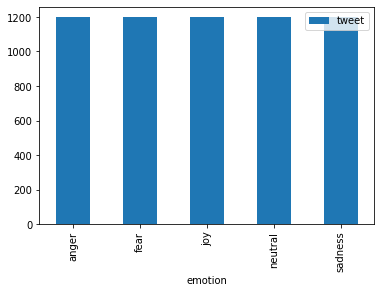

         tweet
emotion       
anger     1200
fear      1200
joy       1200
neutral   1200
sadness   1200


In [4]:
df_train = pd.read_csv("wassa_train.csv")
df_val = pd.read_csv("wassa_val.csv")
df_test = pd.read_csv("wassa_test.csv")

n_samples = df_train[["tweet", "emotion"]].groupby("emotion").count()
n_samples.plot(kind="bar")
plt.show()

print(n_samples)

In [5]:
emotions_list=["joy", "anger", "fear", "sadness", "neutral"]

In [6]:
texts_train = df_train.tweet.tolist()
texts_val = df_val.tweet.tolist()
texts_test = df_test.tweet.tolist()

label_encoder = LabelEncoder()
emotions_train = label_encoder.fit_transform(df_train.emotion.tolist())
emotions_val = label_encoder.transform(df_val.emotion.tolist())
emotions_test = label_encoder.transform(df_test.emotion.tolist())

#Preprocessing the dataset

In [7]:
def preprocess_text(text_list):
  for i, text in enumerate(text_list):
    # eliminate URLs
    result = re.result = re.sub(r"http\S+", "", text)
    # eliminate email addresses
    result = re.sub('\S*@\S*\s?', '', result)
    text_list[i] = result

In [8]:
preprocess_text(texts_train)
preprocess_text(texts_val)
preprocess_text(texts_test)

# Useful functions

In [9]:
def pickle_object(object, location):
    filehandler = open(location, "wb")
    pickle.dump(object, filehandler)
    filehandler.close()

def pickle_load_object(location):
    file = open(location, 'rb')
    object = pickle.load(file)
    file.close()
    return object

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

def compute_metrics(y_true, predictions):
  average = "macro"
  acc = accuracy_score(y_true, predictions)
  precision = precision_score(y_true, predictions, average=average)
  recall = recall_score(y_true, predictions, average=average)
  f1 = f1_score(y_true, predictions, average=average)
  print(f"Model has acc = {acc}\n, precision = {precision}\n, recall = {recall}\n, f1_score = {f1}\n")




# Model and tokenizer selection functions





In [10]:
def get_model(model_name):
  model = None
  if model_name == 'bert-base-cased':
      model = BertModel.from_pretrained(model_name)

  if model_name == 'roberta-base':
      model = RobertaModel.from_pretrained(model_name)
 
  if model_name == 'vinai/bertweet-base':
      model = AutoModel.from_pretrained(model_name)

  return model

def get_tokenizer(model_name):
    tokenizer = None
    if model_name == 'bert-base-cased':
      tokenizer = BertTokenizer.from_pretrained(model_name)

    if model_name == 'roberta-base':
      tokenizer = RobertaTokenizer.from_pretrained(model_name)

    if model_name == 'vinai/bertweet-base':
      tokenizer = AutoTokenizer.from_pretrained(model_name, normalization=True, use_fast=False)
    
    return tokenizer

# Choosing the device and model

In [12]:
# this colab supports training for bert-base-cased roberta-base vinai/bertweet-base models
PRE_TRAINED_MODEL_NAME = 'vinai/bertweet-base'
tokenizer = get_tokenizer(PRE_TRAINED_MODEL_NAME)
if tokenizer is None:
  print("Wrong model! Choose another one.")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [13]:
epoch_dict = {"bert-base-cased" : 5, "roberta-base":5, "vinai/bertweet-base":5}
maxlen_dict = {"bert-base-cased" : 85, "roberta-base":170, "vinai/bertweet-base":90}

In [14]:
EPOCHS = epoch_dict[PRE_TRAINED_MODEL_NAME]
BATCH_SIZE = 16 # higher batch size might aid in the latter stages of fine tuning
maxlen = maxlen_dict[PRE_TRAINED_MODEL_NAME]
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

# Building the PyTorch datasets and dataloaders

In [15]:
class WassaDataset(Dataset):

  def __init__(self, texts, emotions, tokenizer, max_len):
    self.texts = texts
    self.emotions = emotions
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, item):
    text = str(self.texts[item])
    emotion = self.emotions[item]
    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'emotions': torch.tensor(emotion, dtype=torch.long)
    }

In [16]:
def create_data_loader(texts, emotions, tokenizer, max_len, batch_size):
  dataset = WassaDataset(
    texts=texts,
    emotions=emotions,
    tokenizer=tokenizer,
    max_len=max_len)

  return DataLoader(
    dataset,
    batch_size=batch_size,
    num_workers=2
  )

In [17]:
train_data_loader = create_data_loader(texts_train, emotions_train, tokenizer, maxlen, BATCH_SIZE)
val_data_loader = create_data_loader(texts_val, emotions_val, tokenizer, maxlen, BATCH_SIZE)
test_data_loader = create_data_loader(texts_test, emotions_test, tokenizer, maxlen, BATCH_SIZE)

# Building the model

In [18]:
class EmotionsClassifier(nn.Module):
  def __init__(self, n_classes, model_name):
    super(EmotionsClassifier, self).__init__()
    self.bert = get_model(model_name)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.drop(pooled_output)
    output = self.out(output)
    return self.softmax(output)

In [19]:
model = EmotionsClassifier(len(emotions_list), PRE_TRAINED_MODEL_NAME)
model.to(device)

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


EmotionsClassifier(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((

In [20]:
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.NLLLoss().to(device)

# Training and validation

In [21]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    emotions = d["emotions"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, emotions)
    correct_predictions += torch.sum(preds == emotions)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [22]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      emotions = d["emotions"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, emotions)
      correct_predictions += torch.sum(preds == emotions)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [23]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(texts_train)
  )

  print(f'Training loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(texts_val)
  )

  print(f'Validation loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/5
----------
Training loss 0.6875311532219252 accuracy 0.7545
Validation loss 0.4087067320942879 accuracy 0.8706666666666666

Epoch 2/5
----------
Training loss 0.27818441827595236 accuracy 0.9166666666666666
Validation loss 0.3897572157389306 accuracy 0.892

Epoch 3/5
----------
Training loss 0.15158430242414275 accuracy 0.9571666666666666
Validation loss 0.45050122682995936 accuracy 0.888

Epoch 4/5
----------
Training loss 0.09332054699709018 accuracy 0.9766666666666667
Validation loss 0.4823448762119292 accuracy 0.8946666666666666

Epoch 5/5
----------
Training loss 0.06299994616086284 accuracy 0.9851666666666666
Validation loss 0.5013341884564687 accuracy 0.8933333333333333

CPU times: user 10min 43s, sys: 37.7 s, total: 11min 20s
Wall time: 11min 29s


# Plotting training history

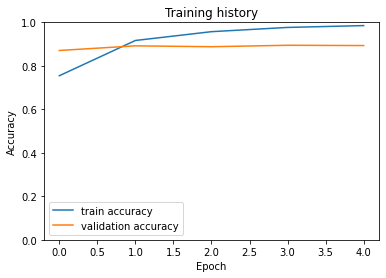

In [24]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

# BERT_model Class





In [25]:
class Bert_model:
  def __init__(self, model, encoder, tokenizer, maxlen):
    self._model = model
    self._encoder = encoder
    self._tokenizer = tokenizer
    self._device = "cpu"
    self._maxlen = maxlen

  def set_device(self, device):
    self._device = device
    self._model.to(device)

  def _preprocess_text(self, text):
      # eliminate URLs
      result = re.result = re.sub(r"http\S+", "", text)
      # eliminate email addresses
      result = re.sub('\S*@\S*\s?', '', result)
      return result

  def _make_prediction_for_text(self, text):
    text = self._preprocess_text(text)
    encoding = self._tokenizer.encode_plus( 
        text,
        add_special_tokens=True,
        max_length=self._maxlen,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(self._device)
    attention_mask = encoding['attention_mask'].to(self._device)
    outputs = self._model(
        input_ids=input_ids,
        attention_mask=attention_mask
    )
    outputs.to(self._device)
    return outputs.cpu().detach().numpy()

  def detect_emotions_with_labels(self, texts):
    predicted_emotions = []
    for text in texts:
      emotion = self._make_prediction_for_text(text)
      pred = np.argmax(emotion, axis=1)
      prediction = self._encoder.inverse_transform(pred)
      predicted_emotions.append(prediction[0])
    return predicted_emotions
  
  def detect_emotions_with_proba(self, texts):
    predicted_emotions = []
    for text in texts:
      emotion_proba = self._make_prediction_for_text(text)
      predicted_emotions.append(emotion_proba)
    return np.concatenate(predicted_emotions)

In [26]:
bert_model = Bert_model(model, label_encoder, tokenizer, maxlen)

In [27]:
bert_model.set_device("cuda")

## Bert model validation

In [28]:
bert_predictions = bert_model.detect_emotions_with_labels(texts_val)
y_true = label_encoder.inverse_transform(emotions_val)
compute_metrics(y_true, bert_predictions)

Model has acc = 0.8933333333333333
, precision = 0.8952338426458258
, recall = 0.8933333333333333
, f1_score = 0.8934422294224647



## Bert model testing

In [29]:
bert_predictions = bert_model.detect_emotions_with_labels(texts_test)
y_true = label_encoder.inverse_transform(emotions_test)
compute_metrics(y_true, bert_predictions)

Model has acc = 0.8866666666666667
, precision = 0.8870296075419415
, recall = 0.8866666666666667
, f1_score = 0.8865121318990765



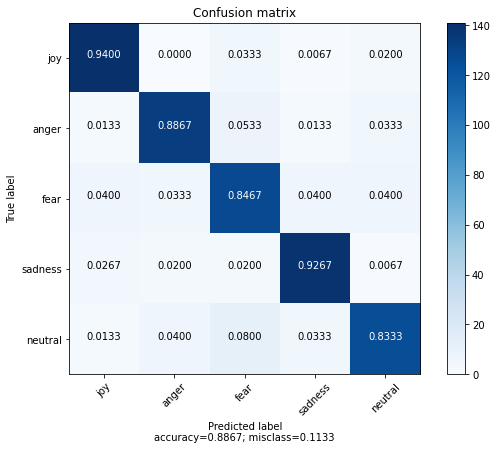

In [30]:
cm = confusion_matrix(y_true, bert_predictions, labels=emotions_list)
plot_confusion_matrix(cm, emotions_list)

# Building the ensemble model

## Adding the SVM model to the ensemble model

In [31]:
class SVM_model:
  def __init__(self, classifier, encoder, emodict, stop_words, vectorizer):
    self._classifier = classifier
    self._encoder = encoder
    self._emodict = emodict
    self._stop_words = stop_words
    self._vectorizer = vectorizer
  
  def _preprocess_text(self, text, emodict, stop_words):
    # make lowercase and strip empty spaces
      result = text.lower()
      # replace emojis with text
      dict = demoji.findall(result)

      for x in dict:
          result = result.replace(x, dict[x] + " ")

      for x in emodict:
          result = result.replace(x, emodict[x] + " ")
      # strip extra spaces
      result = result.strip()
      # eliminate URLs
      result = re.result = re.sub(r"http\S+", "", result)
      # eliminate email addresses
      result = re.sub('\S*@\S*\s?', '', result)
      # strip diacritics
      result = unidecode.unidecode(result)
      # english stopwords
      word_list = word_tokenize(result)
      # english stemmer
      ps = SnowballStemmer("romanian")

      stemmed_sentence = ""
      for word in word_list:
          if word not in stop_words:
              stemmed_sentence += ps.stem(word)
              stemmed_sentence += " "

      result = stemmed_sentence
      whitelist = set('abcdefghijklmnopqrstuvwxyz ABCDEFGHIJKLMNOPQRSTUVWXYZ')
      result = ''.join(filter(whitelist.__contains__, result))
      result = ''.join([i for i in result if not i.isdigit()])
      return result

  def _vectorize_texts(self, texts):
    vectorized_texts = []
    for text in texts:
      processed_text = self._preprocess_text(text, self._emodict, self._stop_words)
      vectorized_texts.append(processed_text)
    return self._vectorizer.transform(vectorized_texts)

  def detect_emotions_with_labels(self, texts):
    vectorized_texts = self._vectorize_texts(texts)
    predictions = self._classifier.predict_log_proba(vectorized_texts)
    predictions  = list(self._encoder.inverse_transform(np.argmax(predictions, axis=1)))
    return predictions

  def detect_emotions_with_proba(self, texts):
    vectorized_texts = self._vectorize_texts(texts)
    predictions = self._classifier.predict_log_proba(vectorized_texts)
    return predictions

  def proba_to_labels(self, proba):
      labels  = list(self._encoder.inverse_transform(np.argmax(proba, axis=1)))
      return labels

In [32]:
svm_model = pickle_load_object("svm_model.obj")

## Ensemble model testing

In [35]:
bert_predictions = bert_model.detect_emotions_with_proba(texts_test)
svm_predictions = svm_model.detect_emotions_with_proba(texts_test)
# combine results for the ensemble model
predictions = svm_predictions+bert_predictions 

In [36]:
y_true = label_encoder.inverse_transform(emotions_test)

In [37]:
# get labels from ensemble model
predicted_emotions_inv = svm_model.proba_to_labels(predictions)

In [38]:
acc = accuracy_score(y_true, predicted_emotions_inv)
acc

0.9173333333333333

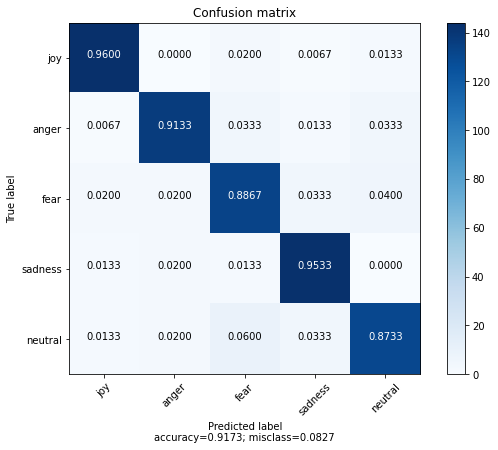

In [39]:
cm = confusion_matrix(y_true, predicted_emotions_inv, labels=emotions_list)
plot_confusion_matrix(cm, emotions_list)

## Ensemble model class

In [40]:
class Ensemble_Model:
  def __init__(self, bert_model, svm_model):
    self._bert_model = bert_model
    self._svm_model = svm_model
  
  def set_bert_device(self, device):
    self._bert_model.set_device(device)

  def detect_emotions(self, texts):
    svm_predictions = self._svm_model.detect_emotions_with_proba(texts)
    bert_predictions = self._bert_model.detect_emotions_with_proba(texts)
    predictions = svm_predictions+bert_predictions
    return self._svm_model.proba_to_labels(predictions)


##  Ensemble model validation

In [41]:
en_model = Ensemble_Model(bert_model, svm_model)

In [42]:
en_model.set_bert_device("cuda")

In [43]:
predictions = en_model.detect_emotions(texts_test)

In [45]:
acc = accuracy_score(df_test.emotion.tolist(), predictions)
acc

0.9173333333333333

In [46]:
pickle_object(en_model, "english_model.obj")